In [1]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os
import cv2
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


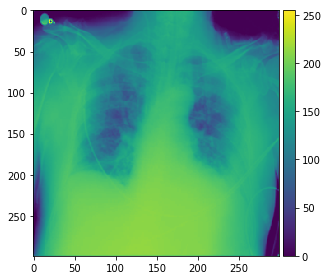

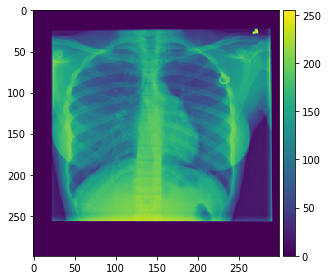

In [3]:
path_Covid = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\CNN\Clasificador\Dataset 3\COVID' 
path_Normal = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\CNN\Clasificador\Dataset 3\Normal'

#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)
        if (len(originalImage.shape)==2):
            originalImage = imread(path1)[:,:]
        if (len(originalImage.shape)==3):
            originalImage = imread(path1)[:,:,0]
        #print(originalImage.shape)
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)
nombres = ['Covid', 'Normal']

### Separamos la data la etiquetamos normalizamos y cargamos por un batch

In [4]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299)) ## torch se convierte nuestra data en tensor - Aumenta la dimension.
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299)) # (-1: Cantidad de imagenes, 1: gris o color, 299 x 299: tamaño de la imagen

img_covidlist = []
for i in range(covid.shape[0]):
      img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
      img_normallist.append((normal[i]/255.0,1.0))

import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:int(len(img_covidlist)*0.8)]
covid_validation = img_covidlist[int(len(img_covidlist)*0.8):int(len(img_covidlist)*0.9)]
covid_test = img_covidlist[int(len(img_covidlist)*0.9):]

random.shuffle(img_normallist)
normal_train = img_normallist[0:int(len(img_normallist)*0.8)]
normal_validation = img_normallist[int(len(img_normallist)*0.8):int(len(img_normallist)*0.9)]
normal_test = img_normallist[int(len(img_normallist)*0.9):]


train_beta = covid_train + normal_train 
validation_beta = covid_validation + normal_validation
test_beta = covid_test + normal_test 

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

### Arquitectura del modelo

### Modelo

In [8]:
torch.manual_seed(22)
#hyperparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN4, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=11, stride=4, padding=0), #73 x 73
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2,padding=1), #36 x 36
            nn.Dropout(p=0.8))
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=0),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=4, padding=1),
            nn.Dropout(p=0.2))
        self.fc1 = nn.Linear(5*5*64, 5*5*64)
        self.fc2 = nn.Linear(5*5*64, 5*5*64)
        self.fc3 = nn.Linear(5*5*64, num_classes)
                      
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out 

In [9]:
def train(model, optimizer, loos_fn, num_epochs):
    loss_vals = []
    running_loss =0.0
    # train the model
    total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

    list_loss_train= []
    list_loss_validation = []
    list_time = []
    j=0
    
    best_loss = 0
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            # forward 
            output = model(images).float()
            #Calucla el loss
            loss   = loss_fn(output, labels)
            # change the params
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Backward 
            loss.backward()
            #parametros update
            optimizer.step()
            train_loss +=loss.item()
            list_time.append(j)
            j+=1

            if (i+1) % 100 == 0:
                  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                    
        list_loss_train.append(train_loss / len(train_loader))
        
        #validation of the model
        valid_loss =0.0   
        for i, (images, labels) in enumerate(test_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            # Forward Pass
            output = model(images).float()
            # Find the Loss
            loss   = loss_fn(output, labels)
            # Calculate loss
            valid_loss +=loss.item()
        #Save loss in a List
        
        list_loss_validation.append(valid_loss / len(test_loader))
        ###Early stopping###
        if valid_loss > best_loss:
            best_loss = valid_loss
            # At this point also save a snapshot of the current model
            torch.save(model, 'my_model_best_loss.pth')
        
        print(f'Epoch {epoch+1} Training Loss: {train_loss / len(train_loader)} Validation Loss: {valid_loss / len(validation_loader)}')  
    
    print('Finished Training Trainset')
    return list_loss_train,list_loss_validation, best_loss, model

In [10]:
model         = CNN4(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([e.shape for e in model.fc3.parameters()])

[torch.Size([4, 1600]), torch.Size([4])]


In [11]:
%%time
list_loss_train,list_loss_validation, best_loss, model = train(model,optimizer,loss_fn, num_epochs=20)

Epoch [1/20], Step [100/100], Loss: 0.2973
Epoch 1 Training Loss: 1.2542536152619868 Validation Loss: 0.3844934389568292
Epoch [2/20], Step [100/100], Loss: 0.0188
Epoch 2 Training Loss: 0.6070399661640659 Validation Loss: 0.4273577346824683
Epoch [3/20], Step [100/100], Loss: 0.0304
Epoch 3 Training Loss: 0.3133160907740239 Validation Loss: 0.15288487134071496
Epoch [4/20], Step [100/100], Loss: 0.0818
Epoch 4 Training Loss: 0.18379860783461482 Validation Loss: 0.1667156248138501
Epoch [5/20], Step [100/100], Loss: 0.1968
Epoch 5 Training Loss: 0.1796757463272661 Validation Loss: 0.10847471410838458
Epoch [6/20], Step [100/100], Loss: 0.0844
Epoch 6 Training Loss: 0.1615452915779315 Validation Loss: 0.11303536780178547
Epoch [7/20], Step [100/100], Loss: 0.3728
Epoch 7 Training Loss: 0.1490069263940677 Validation Loss: 0.12900125536207968
Epoch [8/20], Step [100/100], Loss: 0.0342
Epoch 8 Training Loss: 0.1431806040275842 Validation Loss: 0.09814176301901731
Epoch [9/20], Step [100/10

In [12]:
%%time
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 200 test images: 97.5 %
Wall time: 802 ms


Wall time: 0 ns


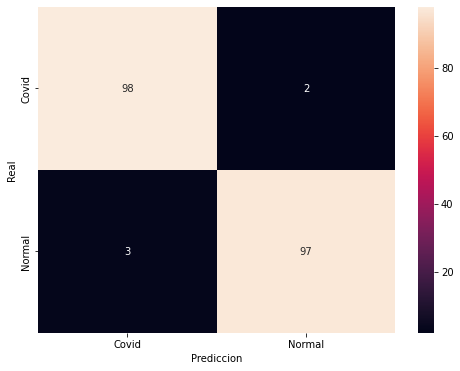

In [13]:
%time
from sklearn.metrics import confusion_matrix
import itertools
nombres = ['Covid', 'Normal']
confusion_matrix_modelo4=confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_modelo4, xticklabels=nombres, yticklabels=nombres, annot =True, fmt= 'd')
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

Wall time: 0 ns


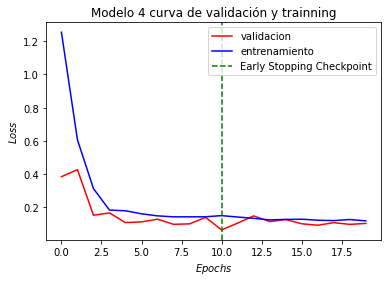

In [14]:
%time
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
# find position of lowest validation loss
minposs = list_loss_validation.index(min(list_loss_validation)) 
plt.axvline(minposs, linestyle='--', color='g',label='Early Stopping Checkpoint')

plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')
plt.title('Modelo 4 curva de validación y trainning')
plt.legend()
plt.show()